# Credits

 As new Kaggler I was inspired by my peers, especially Robert Hatch's notebook [here](https://www.kaggle.com/code/roberthatch/gislr-lb-0-63-on-the-shoulders/notebook) and Lonnie's notebook [here](https://www.kaggle.com/code/lonnieqin/isolated-sign-language-recognition-with-dnn) which helped me a lot to understand this competition.
<br>
And also by Mayukh Bhattacharyya with his [EDA notebook](https://www.kaggle.com/code/mayukh18/sign-language-eda-visualization)

Of course, as newbie, I am open to all proposals for improvement.

# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import os
import random
import json
import glob

In [2]:
# Install nb_black for autoformatting
!pip install nb_black --quiet
%load_ext lab_black

# Set-up & Reproducible

In [3]:
# Constante
ROWS_PER_FRAME = 543
data_dir = "/kaggle/input/asl-signs"
landmark_fimes_dir = "/kaggle/input/asl-signs/train_landmark_files"

In [4]:
def seed_it_all(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


seed_it_all()  # Reproducible

In [5]:
# ROWS_PER_FRAME = 543  # number of landmarks per frame
def load_relevant_data_subset(pq_path):
    data_columns = ["x", "y", "z"]
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [6]:
def read_json(path):
    with open(path, "r") as file:
        json_data = json.load(file)
    return json_data

## load data

In [7]:
train_df = pd.read_csv(data_dir + "/train.csv")
train_df["path"] = data_dir + "/" + train_df["path"]
display(train_df.head(2)), len(train_df)

,path,participant_id,sequence_id,sign
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait


(None, 94477)

In [8]:
s2p_map = read_json(os.path.join(data_dir, "sign_to_prediction_index_map.json"))
p2s_map = {v: k for k, v in s2p_map.items()}

encoder = lambda x: s2p_map.get(x)
decoder = lambda x: p2s_map.get(x)

train_df["label"] = train_df["sign"].map(encoder)
print(f"shape = {train_df.shape}")

train_df.head(2)

shape = (94477, 5)


,path,participant_id,sequence_id,sign,label
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow,25
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait,232


# Quick EDA (Exploratory data analysis)

As explain in the ['Dataset Description' section](https://www.kaggle.com/competitions/asl-signs/data) :

The landmarks were extracted from raw videos with the [MediaPipe holistic model](https://google.github.io/mediapipe/solutions/holistic.html). 
Not all of the frames necessarily had visible hands or hands that could be detected by the model.
<img src="https://mediapipe.dev/images/mobile/holistic_pipeline_example.jpg"  width="800" height="600">

In [9]:
participants = os.listdir(landmark_fimes_dir)
print(f"Total number of participants = {len(participants)}")
print(
    f"Average number of sequences per participant = {len(glob.glob(landmark_fimes_dir + '/*/*.parquet'))/len(participants)}"
)

Total number of participants = 21
Average number of sequences per participant = 4498.9047619047615


In [10]:
int(21 * 4498.9), train_df.shape[0]  # ~ same

(94476, 94477)

First Sequence of the first participant in our dataset :

In [11]:
sample_path = train_df.path[0]
sample = pd.read_parquet(sample_path)

print(f"Sample shape = {sample.shape}")
print(f"Number of Frames = {int(len(sample) / ROWS_PER_FRAME)}")
# ROWS_PER_FRAME = 543 i.e. one frame is represented by 543 row in our dataset, including the face, both hands and pose
# n_frame can also be found : 20->42=>23frames i.e. sample.frame.max() -> sample.frame.min() : sample.nunique()

display(sample), display(sample.iloc[541:544])

Sample shape = (12489, 7)
Number of Frames = 23


,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283
3,20,20-face-3,face,3,0.489788,0.321780,-0.040622
4,20,20-face-4,face,4,0.495304,0.341821,-0.061152
...,...,...,...,...,...,...,...
12484,42,42-right_hand-16,right_hand,16,0.001660,0.549574,-0.145409
12485,42,42-right_hand-17,right_hand,17,0.042694,0.693116,-0.085307
12486,42,42-right_hand-18,right_hand,18,0.006723,0.665044,-0.114017
12487,42,42-right_hand-19,right_hand,19,-0.014755,0.643799,-0.123488


,frame,row_id,type,landmark_index,x,y,z
541,20,20-right_hand-19,right_hand,19,0.350728,0.399582,-0.060217
542,20,20-right_hand-20,right_hand,20,0.385796,0.401101,-0.064718
543,21,21-face-0,face,0,0.501150,0.380554,-0.031570


(None, None)

In [12]:
sample.isna().sum()  # probably the hand as explain in the 'Dataset Description' section

frame               0
row_id              0
type                0
landmark_index      0
x                 735
y                 735
z                 735
dtype: int64

## Load data for evaluation

In [13]:
sample_data_np = load_relevant_data_subset(sample_path)
print(f"shape = {sample_data_np.shape} = (n_frames, row_per_frame, xyz) \n")
sample_data_np[:1, :4, :]

shape = (23, 543, 3) = (n_frames, row_per_frame, xyz) 



array([[[ 0.49440014,  0.38046983, -0.03062646],
        [ 0.49601725,  0.3507348 , -0.05756483],
        [ 0.5008185 ,  0.35934305, -0.03028346],
        [ 0.48978812,  0.32177976, -0.04062242]]], dtype=float32)

## Right hand sample :
All different types of landmark = ['face', 'left_hand', 'pose', 'right_hand']

In [14]:
sample_path_hand = train_df.path[5]  # 5 : empirical choice
sample_for_hand = pd.read_parquet(sample_path_hand)

print(f"Number of Frames = {int(len(sample_for_hand) / ROWS_PER_FRAME)}")
print(f"First frame indice is {sample_for_hand.frame.min()}")
print(f"Last frame indice is {sample_for_hand.frame.max()}")
print(f"Sample signe is : {train_df.sign[5]}")

right_hand_sample = sample_for_hand[sample_for_hand.type == "right_hand"]
left_hand_sample = sample_for_hand[sample_for_hand.type == "left_hand"]
right_hand_sample.head(2)

Number of Frames = 30
First frame indice is 20
Last frame indice is 49
Sample signe is : duck


,frame,row_id,type,landmark_index,x,y,z
522,20,20-right_hand-0,right_hand,0,0.255993,0.540393,7.167730e-07
523,20,20-right_hand-1,right_hand,1,0.320184,0.544032,-4.895598e-02


***duck* sign language :**

![duck sign language](https://images.twinkl.co.uk/tr/image/upload/t_illustration/illustation/Auslan-Duck-Sign--Australian-Sign-Language-KS2.png)

In [15]:
print(
    f"Percentage of nulls in Right Hand data = {100*np.mean(right_hand_sample['x'].isnull()):.2f} %"
)
print(
    f"Percentage of nulls in Left Hand data = {100*np.mean(left_hand_sample['x'].isnull()):.02f} %"
)

Percentage of nulls in Right Hand data = 0.00 %
Percentage of nulls in Left Hand data = 100.00 %


## Visualizing (duck sign)

<img src="https://mediapipe.dev/images/mobile/hand_landmarks.png"  width="600" height="300">


In [16]:
edges = [
    (0, 1),
    (1, 2),
    (2, 3),
    (3, 4),
    (0, 5),
    (0, 17),
    (5, 6),
    (6, 7),
    (7, 8),
    (5, 9),
    (9, 10),
    (10, 11),
    (11, 12),
    (9, 13),
    (13, 14),
    (14, 15),
    (15, 16),
    (13, 17),
    (17, 18),
    (18, 19),
    (19, 20),
]  # see above


def plot_frame(df, frame_id, ax):
    df = df[df.frame == frame_id].sort_values(["landmark_index"])
    x = list(df.x)
    y = list(df.y)

    ax.scatter(df.x, df.y, color="dodgerblue")
    for i in range(len(x)):
        ax.text(x[i], y[i], str(i))

    for edge in edges:
        ax.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], color="salmon")
        ax.set_title(f"Frame no. {frame_id}")
        ax.axis(False)


def plot_frame_seq(df, frame_id_range, n_frames):
    frames = np.linspace(
        frame_id_range[0], frame_id_range[1], n_frames, dtype=int, endpoint=True
    )
    fig, ax = plt.subplots(n_frames, 1, figsize=(5, 25))
    for i in range(n_frames):
        plot_frame(df, frames[i], ax[i])

    plt.show()

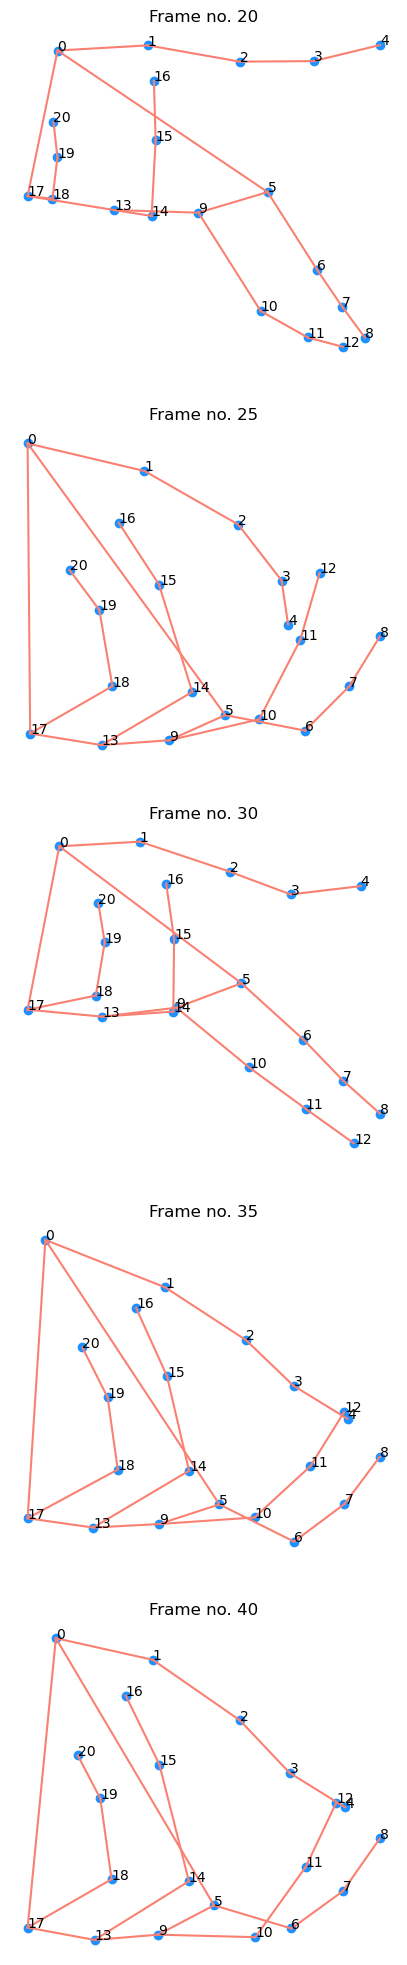

In [17]:
plot_frame_seq(right_hand_sample, (20, 40), 5)  # take 1 frame out of 4

**Looks like the image is up side down, comparing to the duck sign language**

# Baseline model

data shape is (n_frame, row_per_frame, xyz) 
- n_frame is not constante => probleme
- row_per_frame = 543
- xyz = 3

The baseline model will take the mean of all the frame and replace the `NaN` values ny `0`

## Create dataset



In [18]:
class FeatureGen(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x = np.mean(x, axis=0)
        return x


feature_converter = FeatureGen()

In [19]:
data_lenght_experiment = len(train_df)
data_lenght_experiment

94477

In [20]:
def convert_row(row):
    x = load_relevant_data_subset(os.path.join("/kaggle/input/asl-signs", row.path))
    x = feature_converter(x)
    return x, row.label

In [21]:
def convert_and_save_data():
    np_features = np.zeros((data_lenght_experiment, ROWS_PER_FRAME, 3))
    np_labels = np.zeros(data_lenght_experiment)

    print(f"Total data to processe : {data_lenght_experiment}")
    for index, row in tqdm(train_df.iterrows()):
        if index > data_lenght_experiment - 1:
            break

        data = load_relevant_data_subset(row.path)
        feature, label = convert_row(row)
        np_features[index, :, :] = feature
        np_labels[index] = label

    np.save("features.npy", np_features)
    np.save("labels.npy", np_labels)

In [22]:
try:
    features = np.load("/kaggle/working/feature.npy")
    labels = np.load("/kaggle/working/label.npy")
except:
    convert_and_save_data()

Total data to processe : 94477


94477it [33:41, 46.74it/s]


In [23]:
features = np.load("features.npy")
labels = np.load("labels.npy")

In [24]:
def get_model(n_labels=250, learning_rate=0.001):
    inputs = layers.Input(shape=(ROWS_PER_FRAME, 3))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    # x = layers.Dense(8, activation="relu")(x)
    x = layers.Flatten()(x)
    output = layers.Dense(n_labels, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=output)

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    return model

In [25]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "./ASL_model",
    save_best_only=True,
    restore_best_weights=True,
    monitor="val_accuracy",
    mode="max",
    verbose=False,
)

cb_list = [checkpoint_callback]

X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 543, 3)]          0         
                                                                 
 dense (Dense)               (None, 543, 128)          512       
                                                                 
 dense_1 (Dense)             (None, 543, 64)           8256      
                                                                 
 dense_2 (Dense)             (None, 543, 32)           2080      
                                                                 
 dense_3 (Dense)             (None, 543, 16)           528       
                                                                 
 flatten (Flatten)           (None, 8688)              0         
                                                                 
 dense_4 (Dense)             (None, 250)               217225

In [26]:
try:
    model = tf.keras.models.load_model("./ASL_mode")
except:
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        callbacks=cb_list,
        batch_size=64,
    )

Epoch 1/50
1181/1181 [==============================] - 16s 9ms/step - loss: 5.3063 - accuracy: 0.0208 - val_loss: 4.9327 - val_accuracy: 0.0524
Epoch 2/50
1181/1181 [==============================] - 10s 8ms/step - loss: 4.7241 - accuracy: 0.0761 - val_loss: 4.6019 - val_accuracy: 0.0956
Epoch 3/50
1181/1181 [==============================] - 10s 9ms/step - loss: 4.3757 - accuracy: 0.1167 - val_loss: 4.3580 - val_accuracy: 0.1257
Epoch 4/50
1181/1181 [==============================] - 10s 8ms/step - loss: 4.0537 - accuracy: 0.1605 - val_loss: 4.0995 - val_accuracy: 0.1583
Epoch 5/50
1181/1181 [==============================] - 10s 8ms/step - loss: 3.8124 - accuracy: 0.1960 - val_loss: 3.9236 - val_accuracy: 0.1862
Epoch 6/50
1181/1181 [==============================] - 10s 8ms/step - loss: 3.6125 - accuracy: 0.2260 - val_loss: 3.7872 - val_accuracy: 0.2157
Epoch 7/50
1181/1181 [==============================] - 10s 8ms/step - loss: 3.4437 - accuracy: 0.2551 - val_loss: 3.7136 - val_ac

In [27]:
model = tf.keras.models.load_model("./ASL_model")
score = model.evaluate(X_val, y_val)

591/591 [==============================] - 3s 5ms/step - loss: 3.9701 - accuracy: 0.3166


- guessing = 1/250 = 0.004 
- acc score = 0.3185 (with full data)

**this first model is better than a guessing model**

In [28]:
def get_inference_model(model):
    inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
    x = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
    x = tf.reduce_mean(x, axis=0, keepdims=True)
    x = model(x)
    output = tf.keras.layers.Activation(activation="linear", name="outputs")(x)
    inference_model = tf.keras.Model(inputs=inputs, outputs=output)
    inference_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"]
    )
    return inference_model

In [29]:
inference_model = get_inference_model(model)
inference_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 3)]     0           []                               
                                                                                                  
 tf.math.is_nan (TFOpLambda)    (None, 543, 3)       0           ['inputs[0][0]']                 
                                                                                                  
 tf.zeros_like (TFOpLambda)     (None, 543, 3)       0           ['inputs[0][0]']                 
                                                                                                  
 tf.where (TFOpLambda)          (None, 543, 3)       0           ['tf.math.is_nan[0][0]',         
                                                                  'tf.zeros_like[0][0]',    

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"
# Save the model.
with open(model_path, "wb") as f:
    f.write(tflite_model)

In [31]:
!zip submission.zip $model_path

  adding: model.tflite (deflated 6%)
